In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os, json, math, librosa

import IPython.display as ipd
import librosa.display

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import sklearn.model_selection as sk

from sklearn.model_selection import train_test_split

###Getting genres and Music Files

In [2]:
MUSIC = '/content/drive/My Drive/genres_original'
music_dataset = [] # File locations for each wav file 
genre_target = [] # 
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != '/data/genres_original/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/")[5])

### Testing Audio Files

In [3]:
audio_path = music_dataset[500]
signal , sample_rate = librosa.load(audio_path)
# librosa.load(audio_path, sr=None)
# ipd.Audio(audio_path)

In [4]:
sample_rate

22050

In [5]:
len(signal)

661794

In [6]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)

magnitude

array([37.96789551,  5.80300543,  7.79816679, ...,  7.32629585,
        7.79816679,  5.80300543])

In [7]:
frequency = np.linspace(0,sample_rate,len(magnitude))
frequency

array([0.00000000e+00, 3.33185754e-02, 6.66371509e-02, ...,
       2.20499334e+04, 2.20499667e+04, 2.20500000e+04])

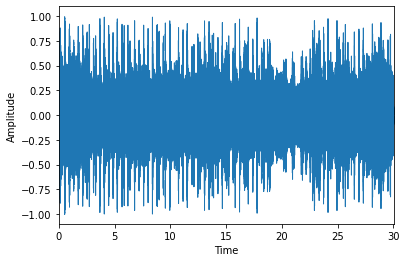

In [8]:
librosa.display.waveplot(signal,sample_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

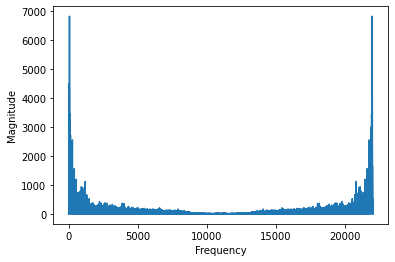

In [9]:
plt.plot(frequency,magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [10]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

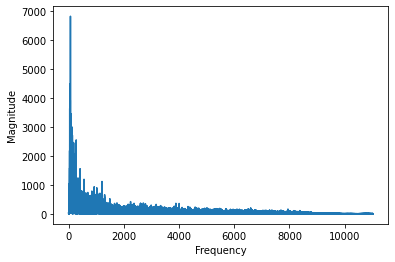

In [11]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [12]:
n_fft = 2048
hop_length = 512
stft = librosa.core.stft(signal, n_fft = n_fft)
spectogram = np.abs(stft)

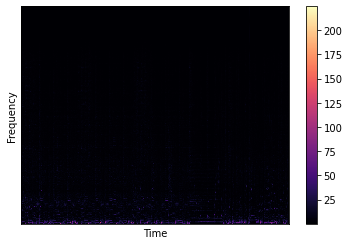

In [13]:
librosa.display.specshow(spectogram , sr = sample_rate, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [14]:
log_spectrogram = librosa.amplitude_to_db(spectogram)

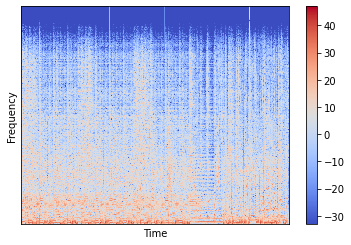

In [15]:
librosa.display.specshow(log_spectrogram , sr = sample_rate, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [16]:
MFCCs = librosa.feature.mfcc(signal,n_fft = n_fft,hop_length = hop_length,n_mfcc=13)

In [17]:
MFCCs

array([[ -12.26583008,  -14.51375274,   -2.5142855 , ..., -147.48827427,
        -174.99661843, -184.33818026],
       [  87.70802396,   99.12684909,  104.46185466, ...,   13.67680642,
          31.73434081,   47.30879869],
       [ -21.21584553,  -21.18764694,  -33.97828172, ...,   11.36915148,
          16.5445933 ,   17.62652992],
       ...,
       [ -10.82796503,   -9.24452063,   -8.9844085 , ...,   -4.77457264,
          -1.39325307,   -7.42741901],
       [  19.60264082,   16.48127486,   13.65519401, ...,   18.78674023,
           7.58632084,    5.25691597],
       [  -4.85265198,  -10.20868747,  -12.16545044, ...,  -19.13625738,
         -18.90371617,  -15.87451535]])

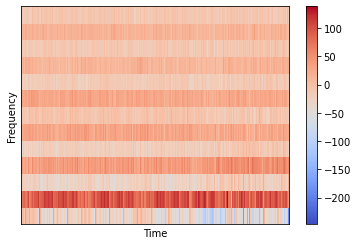

In [18]:
librosa.display.specshow(MFCCs , sr = sample_rate, hop_length = hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [19]:
DATASET_PATH = '/content/drive/My Drive/genres_original'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file

                file_path = os.path.join(dirpath, f)
            
                if file_path != '/content/drive/My Drive/genres_original/jazz/jazz.00054.wav':

                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                
                
                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        # extract mfcc
                        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T

                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

### Runs Data Processing     

In [20]:

save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/genres_original/blues/blues.00072.wav, segment:3
/content/drive/My Drive/genres_original/blues/blues.00072.wav, segment:4
/content/drive/My Drive/genres_original/blues/blues.00072.wav, segment:5
/content/drive/My Drive/genres_original/blues/blues.00072.wav, segment:6
/content/drive/My Drive/genres_original/blues/blues.00073.wav, segment:1
/content/drive/My Drive/genres_original/blues/blues.00073.wav, segment:2
/content/drive/My Drive/genres_original/blues/blues.00073.wav, segment:3
/content/drive/My Drive/genres_original/blues/blues.00073.wav, segment:4
/content/drive/My Drive/genres_original/blues/blues.00073.wav, segment:5
/content/drive/My Drive/genres_original/blues/blues.00073.wav, segment:6
/content/drive/My Drive/genres_original/blues/blues.00077.wav, segment:1
/content/drive/My Drive/genres_original/blues/blues.00077.wav, segment:2
/content/drive/My Drive/genres_original/blues/blues.00077.wav, segment:3


In [22]:
DATA_PATH = '/content/data_10.json'


def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


In [23]:
def prepare_datasets(test_size, validation_size):

    # load data
    X, y, z = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z



In [24]:
def build_model(input_shape):

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [25]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)
    
    # get mappings for target and predicted label
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

In [27]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 214, 11, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 107, 6, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 107, 6, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 105, 4, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 53, 2, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 1, 32)        

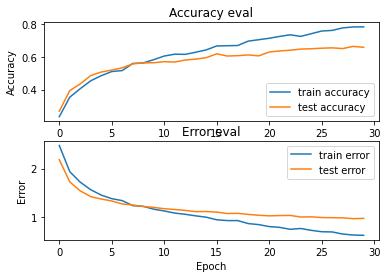

47/47 - 1s - loss: 0.9327 - accuracy: 0.6909

Test accuracy: 0.6909212470054626


In [28]:
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# train model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

### Prediction

In [30]:

X_to_predict = X_test[200]
y_to_predict = y_test[200]

# predict sample
predict(model, X_to_predict, y_to_predict)

Target: metal, Predicted label: ['metal']


# Q4

In [33]:
def model_layer(input_shape,i):

    # build network topology
    model = keras.Sequential()
    if(i==2):
      # 1st conv layer
      model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
      model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
      model.add(keras.layers.BatchNormalization())

      model.add(keras.layers.Flatten())
      model.add(keras.layers.Dense(64, activation='relu'))
      model.add(keras.layers.Dropout(0.3))

      # output layer
      model.add(keras.layers.Dense(10, activation='softmax'))
    elif(i==3):
        # 1st conv layer
      model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
      model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
      model.add(keras.layers.BatchNormalization())

      # 2nd conv layer
      model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
      model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
      model.add(keras.layers.BatchNormalization())

      model.add(keras.layers.Flatten())
      model.add(keras.layers.Dense(64, activation='relu'))
      model.add(keras.layers.Dropout(0.3))

      # output layer
      model.add(keras.layers.Dense(10, activation='softmax'))

    elif(i==4):
          # 1st conv layer
      model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
      model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
      model.add(keras.layers.BatchNormalization())

      # 2nd conv layer
      model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
      model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
      model.add(keras.layers.BatchNormalization())

      # 3rd conv layer
      model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
      model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
      model.add(keras.layers.BatchNormalization())

          # flatten output and feed it into dense layer
      model.add(keras.layers.Flatten())
      model.add(keras.layers.Dense(64, activation='relu'))
      model.add(keras.layers.Dropout(0.3))

      # output layer
      model.add(keras.layers.Dense(10, activation='softmax'))
    
    elif(i==5):

      # 1st conv layer
      model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
      model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
      model.add(keras.layers.BatchNormalization())

      # 2nd conv layer
      model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
      model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
      model.add(keras.layers.BatchNormalization())

      # 3rd conv layer
      model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
      model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
      model.add(keras.layers.BatchNormalization())

      # flatten output and feed it into dense layer
      model.add(keras.layers.Flatten())
      model.add(keras.layers.Dense(64, activation='relu'))
      model.add(keras.layers.Dropout(0.3))

      # output layer
      model.add(keras.layers.Dense(10, activation='softmax'))
      # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [49]:
import time
train = []
test = []
total_time = []
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
layer = [2,3,4,5]
for i in layer:
  model = model_layer(input_shape,i)
  start = time.time()
  # train model
  history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)
  end = time.time()
  time.sleep(1)

  # evaluate model on test set
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=None)
  train_loss, train_acc = model.evaluate(X_train, y_train, verbose=None)
  train.append(train_acc)
  test.append(train_acc)
  total_time.append(end-start)

Epoch 1/30
113/113 [==============================] - 8s 69ms/step - loss: 2.0163 - accuracy: 0.2949 - val_loss: 2.1046 - val_accuracy: 0.3148
Epoch 2/30
113/113 [==============================] - 8s 69ms/step - loss: 1.6369 - accuracy: 0.4139 - val_loss: 1.4556 - val_accuracy: 0.4894
Epoch 3/30
113/113 [==============================] - 8s 69ms/step - loss: 1.4653 - accuracy: 0.4745 - val_loss: 1.3740 - val_accuracy: 0.5328
Epoch 4/30
113/113 [==============================] - 8s 69ms/step - loss: 1.3540 - accuracy: 0.5074 - val_loss: 1.3176 - val_accuracy: 0.5740
Epoch 5/30
113/113 [==============================] - 8s 68ms/step - loss: 1.2207 - accuracy: 0.5658 - val_loss: 1.2484 - val_accuracy: 0.5506
Epoch 6/30
113/113 [==============================] - 8s 68ms/step - loss: 1.0766 - accuracy: 0.6106 - val_loss: 1.1530 - val_accuracy: 0.6174
Epoch 7/30
113/113 [==============================] - 8s 68ms/step - loss: 1.0133 - accuracy: 0.6387 - val_loss: 1.2097 - val_accuracy: 0.5829

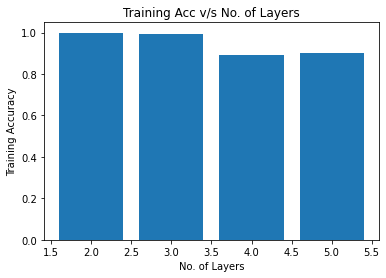

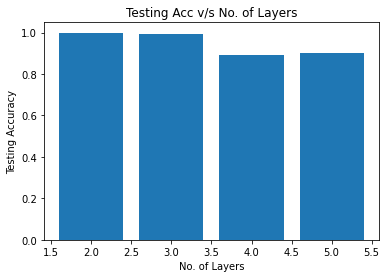

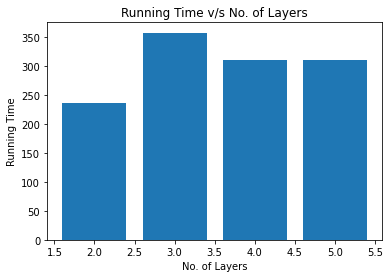

In [51]:
import matplotlib.pyplot as plt 
# creating the bar plot 
plt.bar(layer, train) 

plt.xlabel("No. of Layers") 
plt.ylabel("Training Accuracy") 
plt.title("Training Acc v/s No. of Layers") 
plt.show() 

plt.bar(layer, test ) 
  
plt.xlabel("No. of Layers") 
plt.ylabel("Testing Accuracy") 
plt.title("Testing Acc v/s No. of Layers") 
plt.show() 

plt.bar(layer, total_time ) 
  
plt.xlabel("No. of Layers") 
plt.ylabel("Running Time") 
plt.title("Running Time v/s No. of Layers") 
plt.show() 